# Analyzing posts from r/WritingPrompts

Created in 2010, r/WritingPrompts has grown to become one of the largest subreddits on the platform, with over 15 million members.

Over a decade, hundreds of thousands of prompts have been coallated in this subreddit, offering an interesting corpus of text to examine.

This notebook will seek to examine the frequency of word usage in the subreddit over time, and also attempt to predict the score of a particular post based on it's text



In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import regex as re
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from nltk.stem import WordNetLemmatizer
from nltk import download
import nltk

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

# Data preparation and visualization

In [2]:
# Importing data collected in another notebook for speed
df = pd.read_csv("WPData.csv", index_col=0)
print(df.shape)
df.head(-5)

(876845, 4)


,title,utc,num_comments,score
0,"[WP] Waking up from a hangover, you find yours...",1624815759,1,1
1,[WP] You are born a pied piper. Playing your i...,1624815706,1,1
2,[WP] you see a floating countdown over every p...,1624815642,1,1
3,"[WP] You are a traffic light, witnessing human...",1624814841,1,1
4,Newbie,1624814205,1,1
...,...,...,...,...
876835,On A Related Note: Any Idea Why I Had This For...,1304385556,0,1
876836,Writing Excuses Brainstorms Urban Fantasy with...,1304385464,0,1
876837,Haiku?,1285132191,0,1
876838,Find your character (no. 2): Who's sitting in ...,1284414070,2,3


In [3]:
# Removing all posts not tagged as a writing prompt to get rid of weird data
df = df[df['title'].str.contains('[WP]', regex=False)]

print(df.shape)
df.head(-5)

(656332, 4)


,title,utc,num_comments,score
0,"[WP] Waking up from a hangover, you find yours...",1624815759,1,1
1,[WP] You are born a pied piper. Playing your i...,1624815706,1,1
2,[WP] you see a floating countdown over every p...,1624815642,1,1
3,"[WP] You are a traffic light, witnessing human...",1624814841,1,1
6,"[WP] In the distant future, you are born to a ...",1624812320,1,1
...,...,...,...,...
876744,[WP] The Needs of the Many,1344646528,4,3
876748,[WP] The Final Entry In The Journal,1344610436,9,8
876750,[WP]/[PI] Different Perspectives on Biblical S...,1344603330,4,4
876759,"[WP] Incorporate the sentence anywhere: ""Even ...",1344569132,15,6


This reduces the data by quite a bit, but without it we get a lot of spam posts and non-writing prompts. At the inception of the subreddit posts were not exclusively prompts, which throws off the data, so getting rid of all of it seems like the best solution

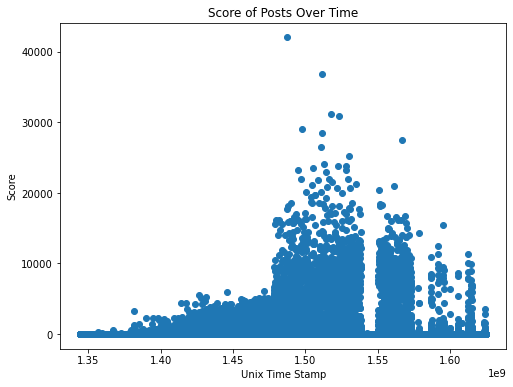

In [4]:
# Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(df['utc'], df['score'])
plt.title("Score of Posts Over Time")
plt.ylabel("Score")
plt.xlabel("Unix Time Stamp")

x = df["utc"]
y = df["score"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

plt.show()

In [5]:
# Looking at top post
print(df.loc[df['score'].idxmax(), "title"])
print(df['score'].mean())
print(df['score'].max())

[WP] The year is 1910. Adolf Hitler, a struggling artist, has fought off dozens of assasination attemps by well meaning time travelers, but this one is different. This traveller doesn't want to kill Hitler, he wants to teach him to paint. He pulls off his hood to reveal the frizzy afro of Bob Ross.
40.00538751729308
42050


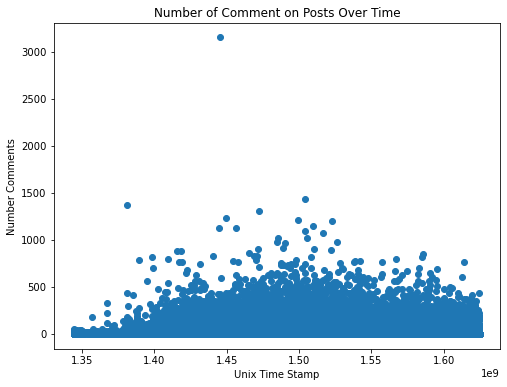

In [6]:
# Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(df['utc'], df['num_comments'])
plt.title("Number of Comment on Posts Over Time")
plt.ylabel("Number Comments")
plt.xlabel("Unix Time Stamp")

x = df["utc"]
y = df["num_comments"]
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

plt.show()

In [7]:
# Looking at top commented post
print(df.loc[df['num_comments'].idxmax(), "title"])
print(df.loc[df['num_comments'].idxmax(), "score"])
print(df['num_comments'].mean())
print(df['num_comments'].max())

[WP] A day before the Earth is destroyed by a collision with a rouge planet, time freezes. You, a completely normal person are untouched and cannot die. Text on your arm appears that reads, "however long it takes, save us".
5919
4.9987079709659135
3151


Looking at the reddit post itself, the only notable thing about it that could have been the cause of the abundance of comments is one particular thread, where a single reddit user wrote a very lengthy story over the course of 20+ comments that was very popular

In [8]:
### BASIC PREPROCESSING ###

# Remove punctuation
df['title'] = df['title'].str.replace(r'[^\w\s]+', '')

# Convert to lowercase
df["title"] = df["title"].str.lower()

# Remove digits
df['title'] = df['title'].str.replace('\d+', '')

# Remove the "wp" and "wppi" at the start of posts
df['title'] = df['title'].str.replace('wp ', '')
df['title'] = df['title'].str.replace('wppi ', '')

In [9]:
df.head(-5)

,title,utc,num_comments,score
0,waking up from a hangover you find yourself in...,1624815759,1,1
1,you are born a pied piper playing your instrum...,1624815706,1,1
2,you see a floating countdown over every person...,1624815642,1,1
3,you are a traffic light witnessing human lives...,1624814841,1,1
6,in the distant future you are born to a normal...,1624812320,1,1
...,...,...,...,...
876744,the needs of the many,1344646528,4,3
876748,the final entry in the journal,1344610436,9,8
876750,different perspectives on biblical stories,1344603330,4,4
876759,incorporate the sentence anywhere even though ...,1344569132,15,6


In [18]:
# Getting a list of each word in the string of all prompts
tokens_stops = ",".join(df["title"]).split()

# Removing stopwords
tokens = [token for token in tokens_stops if token not in stopwords.words("english")]

# Displaying the top 20 word frequencies in a dataframe
df_freq = pd.DataFrame(Counter(tokens).most_common(20), columns=["word", "freq"])
df_freq.head(10)

,word,freq
0,one,105194
1,world,66703
2,time,61112
3,day,57859
4,life,45893
5,people,43703
6,find,43044
7,years,41258
8,youre,40865
9,first,35143


In [19]:
# Lemmatize the tokens
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(token) for token in tokens]

In [20]:
# Get most common words
Counter(tokens).most_common(10)

[('one', 109060),
 ('world', 74691),
 ('time', 65994),
 ('day', 64411),
 ('year', 63429),
 ('life', 52977),
 ('find', 48589),
 ('human', 48574),
 ('people', 46617),
 ('youre', 40865)]

In [21]:
# Splitting the tokenized lemmatized text into 10 blocks by time

timed_tokens = []

for i in range(10):
    timed_tokens.append(tokens[int(len(tokens)/10)*i : int(len(tokens)/10)*(i+1)])

# Reversing it so the earliest chuck comes first
timed_tokens.reverse()

In [22]:
# Counting the words in each chunk of time

count_list = []

for text in timed_tokens:
    
    text_common = Counter(text).most_common(1000)
    
    count_list.append(text_common)

In [23]:
# Creating a dataframe of most common words in each block of time

df_counts = pd.DataFrame()

for i, vals in enumerate(count_list):
    df_counts[f"split{i}"] = vals

df_counts.head(10)

,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9
0,"(one, 9888)","(one, 9824)","(one, 10679)","(one, 11073)","(one, 10873)","(one, 11708)","(one, 11627)","(one, 11392)","(one, 11299)","(one, 10697)"
1,"(world, 7954)","(world, 7901)","(world, 7999)","(world, 7816)","(world, 7484)","(world, 7491)","(day, 7172)","(world, 6975)","(world, 7265)","(world, 6805)"
2,"(year, 6391)","(time, 6495)","(time, 7174)","(time, 6964)","(time, 6725)","(day, 7145)","(world, 7001)","(day, 6756)","(time, 6319)","(time, 6270)"
3,"(day, 5976)","(year, 6358)","(year, 6858)","(day, 6875)","(day, 6601)","(time, 6999)","(time, 6656)","(time, 6433)","(day, 6208)","(year, 5837)"
4,"(time, 5959)","(day, 5722)","(day, 6413)","(year, 6298)","(year, 6480)","(year, 6406)","(year, 6593)","(year, 6088)","(year, 6120)","(day, 5543)"
5,"(life, 5924)","(life, 5336)","(life, 5587)","(life, 5556)","(life, 5343)","(life, 5479)","(life, 5173)","(life, 5128)","(human, 5204)","(human, 5304)"
6,"(find, 5500)","(human, 4663)","(find, 5105)","(find, 5073)","(human, 5075)","(find, 4822)","(youre, 4934)","(human, 4987)","(life, 4835)","(life, 4616)"
7,"(man, 5232)","(find, 4660)","(people, 4850)","(people, 4794)","(find, 5045)","(human, 4821)","(people, 4821)","(youre, 4928)","(people, 4829)","(people, 4514)"
8,"(story, 5064)","(people, 4619)","(human, 4426)","(human, 4473)","(people, 4502)","(youre, 4754)","(human, 4747)","(people, 4777)","(find, 4568)","(youre, 4491)"
9,"(human, 4874)","(story, 4207)","(get, 4159)","(get, 4233)","(youre, 4121)","(people, 4700)","(find, 4740)","(find, 4703)","(youre, 4536)","(find, 4373)"


In [24]:
# Creating a dictionary of the word counts in each bin of time
count_list_dict = [dict(time) for time in count_list]

# Function to plot the word counts in each time bin as a line chart
def plot_word(word):
    
    count_vals = []
    
    for block in count_list_dict:
        try:
            count_vals.append(block[word])
        except KeyError:
            count_vals.append(0)
    
    print(count_vals)
    plt.plot(count_vals)
    
    plt.show()

[9888, 9824, 10679, 11073, 10873, 11708, 11627, 11392, 11299, 10697]


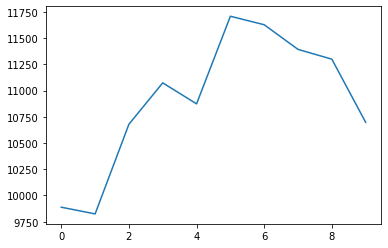

In [25]:
plot_word("one")

[4874, 4663, 4426, 4473, 5075, 4821, 4747, 4987, 5204, 5304]


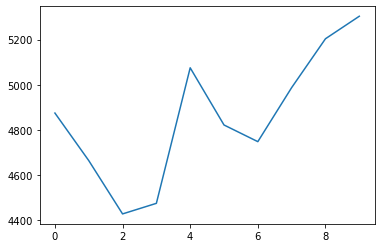

In [26]:
plot_word("human")

[0, 978, 1067, 736, 398, 268, 0, 0, 0, 0]


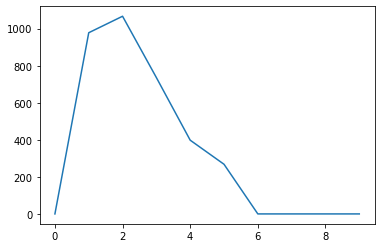

In [27]:
plot_word("trump")

The absolute cratering of the word "Trump" is a little surprising. Though of course he has fallen out of the popular consciousness, this could suggest that moderators now regularly remove posts that feature the word.

[292, 275, 267, 177, 216, 216, 221, 219, 504, 228]


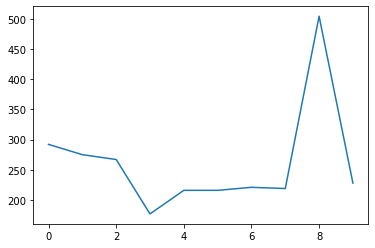

In [32]:
plot_word("virus")

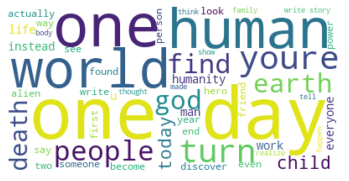

In [28]:
# Word cloud with bigrams
wordcloud = WordCloud(background_color="white", max_words = 50).generate(",".join(tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

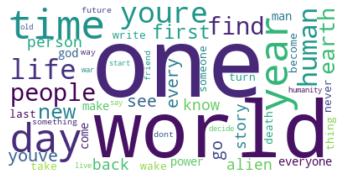

In [29]:
# Word cloud without bigrams
wordcloud = WordCloud(background_color="white", max_words = 50, collocations = False).generate(",".join(tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Machine Learning

In [10]:
# Feature engineering to turn the data into classification - easier to construct a model that way

df_class = df[["title", "score"]]
df_class["score"] = np.where(df_class["score"] > 1, "good", "bad")
df_class.head()

C:\Users\Rohan\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,score
0,waking up from a hangover you find yourself in...,bad
1,you are born a pied piper playing your instrum...,bad
2,you see a floating countdown over every person...,bad
3,you are a traffic light witnessing human lives...,bad
6,in the distant future you are born to a normal...,bad


In [11]:
df_class["score"].value_counts()

good    348589
bad     307743
Name: score, dtype: int64

This gives a fairly well-balanced dataset

In [12]:
X = df_class["title"]
y = df_class["score"]

In [13]:
### CREATING THE MODEL ###

# Traintestsplit the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Get tfidf values
tfidf = TfidfVectorizer()
tfidf.fit(X)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Build and test the classifier
logit_class = LogisticRegression(max_iter=500)
model = logit_class.fit(X_train, y_train)
model.score(X_test, y_test)

0.5673104465422987

In [14]:
# Get the confusion matrix on its predictions

y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[31612, 45315],
       [25682, 61474]], dtype=int64)

As the confusion matrix above shows, the model is best at detecting posts that will fall into the "bad" category, that is to say with 1 or less upvotes.

It is substantially worse at detecting "good" posts, getting very few true positives and many false positives. I would attribute this to the fact that "good" writing prompts can be incredibly varied; the purpose of the subreddit itself is to provide a huge range of propmts submitted by anyone and everyone. Thus, narrowing down the key words that make a prompt likely to be upvoted is difficult.

Detecting the vocabularly likely to prevent a post from gaining traction or to get it downvoted is slightly easier, as simple things like poor spelling, politics, or offensive content are unlikely to garner widespread appeal

In [15]:
# Get most important feature names

feature_names = tfidf.get_feature_names()
top25pos = np.argsort(model.coef_[0])[-25:]
print("Top features for positive posts:")
print(list(feature_names[j] for j in top25pos))
print()
print("Top features for negative posts:")
top25neg = np.argsort(model.coef_[0])[:25]
print(list(feature_names[j] for j in top25neg))

Top features for positive posts:
['mindreader', 'whip', 'radically', 'testify', 'seated', 'exclaiming', 'suspense', 'attendants', 'admire', 'evacuation', 'subtly', 'trillions', 'idealistic', 'hatchet', 'cumulative', 'moth', 'gritty', 'democratically', 'wpat', 'reclusive', 'sympathize', 'escalates', 'uploads', 'purchases', 'mythological']

Top features for negative posts:
['trump', 'covid', 'coronavirus', 'trumps', 'president', 'harambe', 'memes', 'meme', 'hitler', 'pandemic', 'poop', 'rape', 'corona', 'penis', 'feminist', 'ur', 'potus', 'masturbated', 'autism', 'wp', 'fart', 'jones', 'orgasm', 'hitlers', 'cosby']


As mentioned above, the features that the model believes are important for positive posts are a random assortment of words without any real connections between them, as "good" prompts are incredibly varied.

The features for negative posts, however, follow a more common theme. Many are political in nature, specifically mentions of "Trump," "president," "potus," and the like. Several concern more sensitive topics unlikely to garner upvotes. Many are mentions of memes or other more "crude" material.

In [16]:
model = XGBClassifier()

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.5653358361317138

In [17]:
y_pred = model.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[17772, 59155],
       [12166, 74990]], dtype=int64)

The XGBoost model appears to have similar faults to the Logistic Regression model, without significant variance in score or confusion matrix.

## Conclusions

r/WritingPrompts is, as expected, a subreddit with a myriad of disparate posts. Prompts that succeed don't have many obvious linking themes, as part of the appeal of the subreddit is as a place where any and all kinds of genres and prompts can be explored.

In the data, we see how prompts containing "Hitler" are unlikely to do well, yet the top post of all time on the subreddit includes the word. The full context of the prompt has overwhelming importance, and it is not just a handful of words that make or break it.

Most of the top prompts are very specific in nature, and all detail incredibly different scenarios. It is thus difficult to apply machine learning to attempt to predict the score of a prompt as the entire message of the prompt is more important than singular words.

That being said, prompts that are negatively recieved are easier to predict, as although singular words cannot *make* a prompt, they can certainly break it.